### Import python library

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

from math import sqrt

### 1. Read data: augment_24group_1620.csv필요

In [2]:
data = pd.read_csv("model_input_data/augment_24group_1620.csv")

#### 1) 변수 설정

In [301]:
team_val = 'HH'
year_val = 2019

#### 2) Train 전처리

In [302]:
tmp = data.copy()


tmp = tmp[tmp["YEAR"]!=2020]
tmp.head(50)

train = tmp[tmp["IDX"]!=777]
test = tmp[tmp["IDX"]==777]

In [303]:
ttmp = train[(train["T_ID"]==team_val)]
ttmp = ttmp[(ttmp["YEAR"]==year_val)]
ttmp

,T_ID,YEAR,PCT,IDX,MERGE_IDX,HEADER_NO,era,avg,vs_era,vs_avg,...,K_9,vs_ERA,H_A,vs_K_9,vs_FIP,H_9,oSLG,vs_OPS,vs_WHIP,P2_WHIP_RT
3039,HH,2019,0.458333,1,1,0,4.391304,0.269185,4.854874,0.302353,...,7.483792,5.058417,0.416667,8.344375,20.770625,9.449417,0.408542,0.818167,1.577875,2.489167
3040,HH,2019,0.458333,2,2,0,5.717147,0.240099,3.641860,0.254438,...,6.991792,3.751667,0.583333,7.988792,21.016500,11.336917,0.433958,0.683792,1.208583,1.532792
3041,HH,2019,0.291667,3,3,0,4.020370,0.291925,2.972477,0.244946,...,6.268333,2.992875,0.458333,7.756083,14.026458,9.253125,0.370333,0.633125,1.254250,1.697000
3042,HH,2019,0.250000,4,4,0,6.014218,0.260763,3.993843,0.285887,...,6.495833,4.009958,0.583333,7.900292,17.744333,10.704833,0.446208,0.797583,1.318708,2.585917
3043,HH,2019,0.375000,5,5,0,5.652174,0.286219,3.490654,0.281553,...,5.468750,3.536458,0.333333,6.218750,12.201417,11.375000,0.432292,0.718958,1.237167,2.150208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,HH,2019,0.375000,4,93,0,5.619512,0.276394,3.911215,0.279126,...,5.697917,3.953125,0.250000,6.218750,14.159750,11.338542,0.437583,0.712583,1.329792,2.170583
3132,HH,2019,0.500000,1,94,0,5.704225,0.245658,3.924171,0.260766,...,6.939417,4.064167,0.625000,7.988792,20.224833,11.419042,0.435042,0.698792,1.224208,1.731333
3133,HH,2019,0.291667,2,95,0,3.947111,0.294410,2.945455,0.248541,...,6.429042,2.961625,0.416667,7.512333,14.997292,9.371000,0.367125,0.644917,1.258417,1.721667
3134,HH,2019,0.250000,3,96,0,5.957746,0.261294,4.016877,0.281022,...,6.392708,4.030792,0.625000,8.050292,18.127667,10.489208,0.437208,0.788167,1.312208,2.565083


* timestep = 2를 만들기 위해 data shift

In [304]:
aaa = ttmp.loc[:,["IDX","MERGE_IDX","PCT"]]

for i in range(1,3):
    for c in list(set(list(ttmp.columns))-set(['T_ID','YEAR'])):
        aaa.loc[:,'shift_{}_{}'.format(c,i)] = ttmp.loc[:,c].shift(i)
        
# aaa.loc[:,["IDX","MERGE_IDX","PCT"]] = ttmp.loc[:,["IDX","MERGE_IDX","PCT"]]

In [305]:
ttmp = aaa.copy()

In [307]:
ttmp.dropna(inplace = True)
ttmp_idx = list(ttmp.index)
drop_idx = []
for i in ttmp_idx:
    idx_num = ttmp.loc[i,'IDX']
    if idx_num < ttmp.loc[i,'shift_IDX_1'] or idx_num < ttmp.loc[i,'shift_IDX_2']:
        drop_idx.append(i)

In [308]:
shift_data = ttmp.drop(drop_idx).reset_index(drop = True)

# shift_data = pd.concat([shift_data, pd.get_dummies(data.T_ID)], axis = 1)

no_shift_lst= []
for i in list(shift_data.columns):
    if 'shift' not in i:
        no_shift_lst.append(i)

In [309]:
X_train = shift_data.drop(no_shift_lst,axis = 1)
y_train = shift_data[["PCT"]]

In [310]:
X_train.shape, y_train.shape

((49, 140), (49, 1))

#### 4) Test 전처리

In [311]:
sel_col = list(test.columns)

tmp5 = data[(data["IDX"]==5)&(data["T_ID"]==team_val)][sel_col]
tmp4 = data[(data["IDX"]==4) & (data["MERGE_IDX"]==4)&(data["T_ID"]==team_val)][sel_col]

In [312]:
test_df = pd.concat([test[test["T_ID"]==team_val],tmp5,tmp4], axis = 0).sort_values(by=["YEAR","IDX"])

In [313]:
test_df = test_df[test_df["YEAR"]== year_val]

In [314]:
bbb = test_df.loc[:,["IDX","MERGE_IDX","PCT"]]

for i in range(1,3):
    for c in list(set(list(test_df.columns))-set(['T_ID','YEAR'])):
        bbb.loc[:,'shift_{}_{}'.format(c,i)] = test_df.loc[:,c].shift(i)
        
# bbb.loc[:,["IDX","MERGE_IDX","PCT"]] = test_df.loc[:,["IDX","MERGE_IDX","PCT"]]


# for c in list(set(list(test_df.columns))-set(['T_ID','YEAR'])):
#     for i in range(1,3):
#         test_df.loc[:,'shift_{}_{}'.format(c,i)] = test_df.loc[:,c].shift(i)

# for i in range(1,3):
#     test_df.loc[:,'shift_{}_{}'.format('PCT',i)] = test_df.loc[:,'PCT'].shift(i)

In [315]:
test_df = bbb.copy()

In [316]:
test_tmp = test_df[test_df["IDX"]==777]
X_test = test_tmp.drop(no_shift_lst,axis = 1)
y_test = test_tmp[["PCT"]]

In [317]:
X_test

,shift_vs_H_A_1,shift_vs_DER_1,shift_vs_BB_9_1,shift_vs_WHIP_1,shift_vs_WLS_1,shift_oOBP_1,shift_vs_era_1,shift_vs_LOB_1,shift_GPA_1,shift_vs_OPS_1,...,shift_HEADER_NO_2,shift_IDX_2,shift_vs_GPA_2,shift_P_HRA_RT_2,shift_AVG_2,shift_wOBA_2,shift_vs_XR_2,shift_vs_P_WHIP_RT_2,shift_ISO_2,shift_ERA_2
3038,0.666667,0.69475,1.916667,1.237167,0.625,0.351,3.490654,0.7115,0.255167,0.718958,...,0.0,4.0,0.269917,0.295708,0.253083,0.346042,5.474417,1.422167,0.119125,6.153125


#### 4) input shape로 변경 (row, timestep=2, feature)

ex) 
timestep = 2

* X_train_v 구성예시: [[1 ~ 24경기 데이터, 25 ~ 48경기 데이터], [49 ~ 72경기 데이터, 73 ~ 96경기 데이터] ]  
X_train_v.shape >> (2,2*x)             # x: 각 24group에 대한 변수 개수
* y_train_v 구성예시: 97 ~ 120 경기 승률

=> reshape

* X_train_v.shape >> (2,2,x)  # row, timestep, feature

In [326]:
X_train_v = X_train.values
y_train_v = y_train.values

X_test_v = X_test.values
y_test_v = y_test.values

In [327]:
X_train_v.shape, y_train_v.shape, X_test_v.shape, y_test_v.shape

((49, 140), (49, 1), (1, 140), (1, 1))

In [328]:
X_train_t = X_train_v.reshape(X_train_v.shape[0], 2,70)
X_test_t = X_test_v.reshape(X_test_v.shape[0], 2,70)

### 2. 모델 구성(LSTM)
- optimizer: RMSprop -> lr(learning rate) 조절
- LSTM: 모델이 계속 동일한 결과값이 나올 때, input 뉴런 개수를 늘려야 한다는 글을 읽고 계속 input 노드 개수를 바꿔주면서 모델 생성중
- loss: MSE

- early_stop: patience를 크게하면 과적합 되는 경우가 있어서 최대한 작게 설정해둠
- batch_size: 모델이 계속 동일한 결과값이 나올 때, 데이터가 적어 batch size를 줄여보라는 글을 읽고 1로 설정해둠

In [321]:
K.clear_session() 

model = Sequential()
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               216800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 217,001
Trainable params: 217,001
Non-trainable params: 0
_________________________________________________________________


In [293]:
early_stop = EarlyStopping(monitor='loss', mode = 'min',patience=2, verbose=1)


hist1 = model.fit(X_train_t, y_train_v, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Train on 49 samples
Epoch 1/100
49/49 [==============================] - 3s 53ms/sample - loss: 0.0168 - mae: 0.0776
Epoch 2/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0043 - mae: 0.0528 0s - loss: 0.0028 - mae: 0.0
Epoch 3/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0038 - mae: 0.0520
Epoch 4/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0043 - mae: 0.0538
Epoch 5/100
49/49 [==============================] - 0s 7ms/sample - loss: 0.0049 - mae: 0.0591
Epoch 00005: early stopping


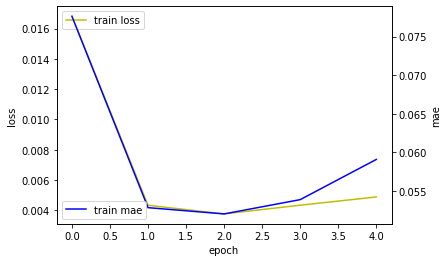

In [294]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 3. 결과 확인

In [295]:
y_pred = model.predict(X_test_t)

In [296]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.335582,0.583333


In [297]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.24775122602780664

### ================================= 결과 ======================================

HH,2018

In [273]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.498883,0.5


In [274]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.001117318868637085

HH, 2019

In [296]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.335582,0.583333


In [297]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.24775122602780664

In [298]:
test_df[["shift_PCT_1","shift_PCT_2","PCT"]]

,shift_PCT_1,shift_PCT_2,PCT
3042,NaN,NaN,0.250000
3043,0.250,NaN,0.375000
3038,0.375,0.25,0.583333


LG, 2019

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [173]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.569255,0.541667


In [174]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.027587850888570187

LG, 2018

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [127]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.414969,0.416667


In [128]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.001697460810343443

LG, 2017

In [ ]:
# K.clear_session() 

# model = Sequential()
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# model.add(LSTM(200,input_shape = (2,70))) # (timestep, feature)
# model.add(Dense(1)) # output = 1
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

# model.summary()

In [103]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.450553,0.434783


In [104]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.015770063452098693

LG, 2016

In [47]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})

,y_pred,y
0,0.516492,0.608696


In [48]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.09220322577849682